In [28]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import os

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [29]:
species_features_paths = {"binary": "../../data/features/plant/binary/features_by_network",
                         "weighted": "../../data/features/plant/weighted/features_by_network/",
                         "binarized_weighted": "../../data/features/plant/binarized_weighted/features_by_network/"}

species_features_output_paths = {"binary": "../../data/features/plant/binary/features.csv",
                         "weighted": "../../data/features/plant/weighted/features.csv",
                         "binarized_weighted": "../../data/features/plant/binarized_weighted/features.csv"}

network_features_dirs = {"binary": "../../data/features/network/binary/features_by_network/",
                         "weighted": "../../data/features/network/weighted/features_by_network/",
                         "binarized_weighted": "../../data/features/network/binarized_weighted/features_by_network/"}

network_features_output_paths = {"binary": "../../data/features/network/binary/features.csv",
                         "weighted": "../../data/features/network/weighted/features.csv",
                         "binarized_weighted": "../../data/features/network/binarized_weighted/features.csv"}

features_of_interest = {"plant": ["partner.diversity", "d", "normalised.degree", "weighted.betweenness", "weighted.closeness"],
                        "network": ["connectance", "NODF", "modularity", "robustness", "robustness_mean", "robustness.LL"]}

species_features_dir = "../../data/features/plant/"
network_features_dir = "../../data/features/network/"

# standarize species features using the rankiong approach of Stouffer et al. 2014

In [12]:
alternative_features_df = []
for network_type in species_features_output_paths:
    features_dir = f"{species_features_dir}{network_type}/"
    if os.path.exists(species_features_output_paths[network_type]):
        features_df = pd.read_csv(species_features_output_paths[network_type])
        features_df["network_type"] = network_type
        alternative_features_df.append(features_df)
    else:
        altenative_paths = {int(p.replace("_features.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features.csv")}
        for p in altenative_paths:
            df = pd.read_csv(altenative_paths[p]).rename(columns={"Unnamed: 0": "Plant"})
            df["network_id"] = int(p)
            df["network_type"] = network_type
            alternative_features_df.append(df)
alternative_features_df = pd.concat(alternative_features_df)
alternative_features_df = alternative_features_df[[c for c in alternative_features_df.columns if not c.startswith("standardized_ ")]]

In [13]:
def get_ranked_features_df(df: pd.DataFrame) -> pd.DataFrame:
    if df.shape[0] == 0:
        return df
    features = [c for c in df.columns if not c.startswith("standardized_") and c not in ["Plant", "network", "network_id", "network_type"]]
    
    for feature in features:
        df[f"standardized_{feature}"] = df[feature].rank()
        max_rank = df[f"standardized_{feature}"].max()
        df[f"standardized_{feature}"] = df[f"standardized_{feature}"] / max_rank
    
    return df

alternative_features_df = alternative_features_df.groupby(["network_type", "network_id"]).parallel_apply(lambda df: get_ranked_features_df(df))

In [14]:
standardized_features = [c for c in alternative_features_df.columns if c.startswith("standarized")]
for f in standardized_features:
    assert(alternative_features_df[f].max() <= 1)
    assert(alternative_features_df[f].max() >= 1)

In [15]:
alternative_features_df.reset_index(inplace=True, drop=True)

In [16]:
for network_type in species_features_output_paths:
    alternative_features_df.query(f"network_type == '{network_type}'").to_csv(species_features_output_paths[network_type])

In [17]:
alternative_features_df = pd.concat([pd.read_csv(species_features_output_paths[network_type]) for network_type in species_features_output_paths])

In [18]:
test = alternative_features_df.query("network_type == 'binary' and network_id == 1")[["Plant", "degree","normalised.degree", "standardized_degree", "standardized_normalised.degree"]].sort_values("degree")

features = ['d', 'normalised.degree', 'weighted.closeness', 'weighted.betweenness', 'partner.diversity']


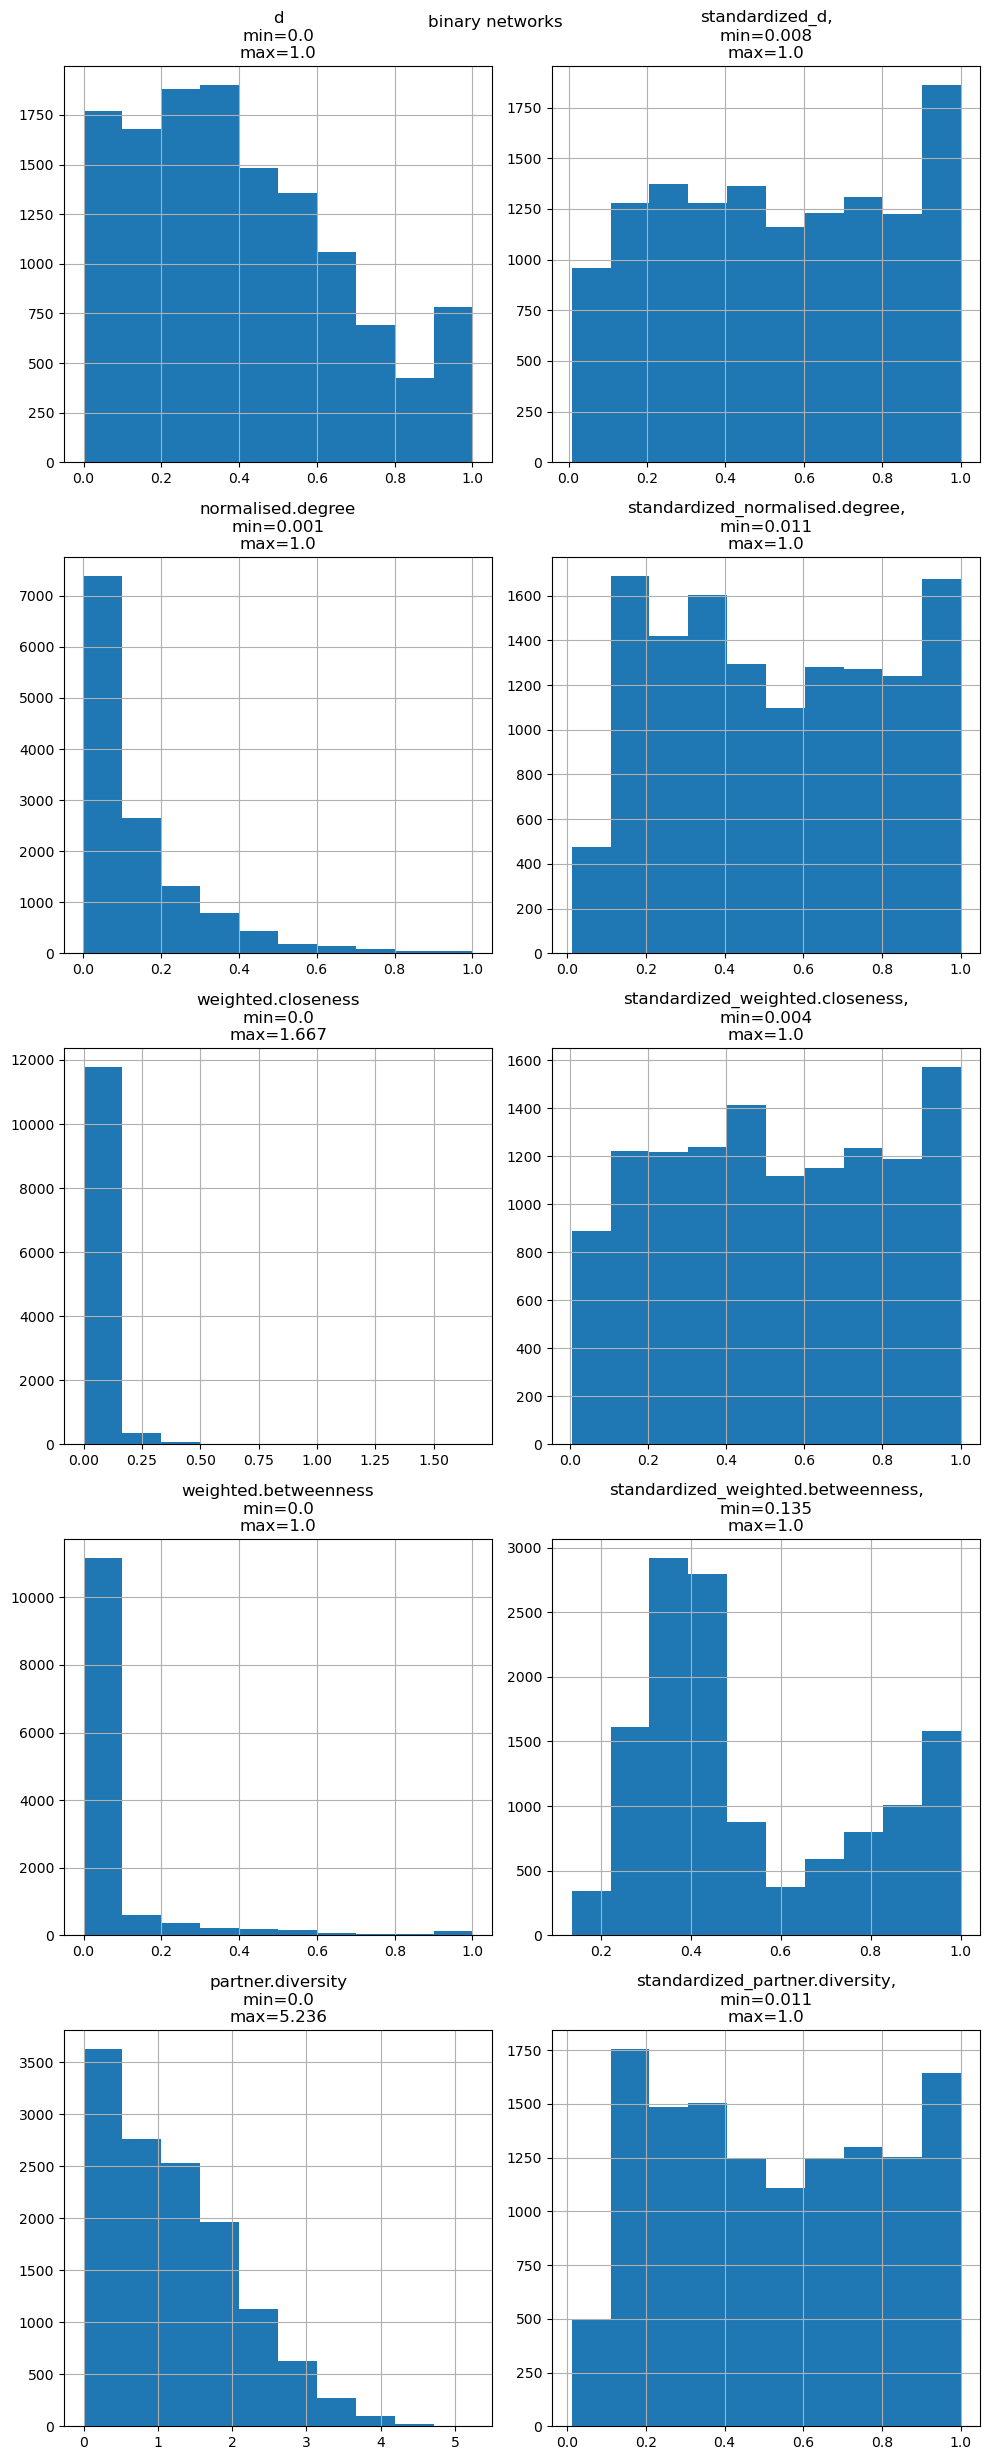

In [19]:
import matplotlib.pyplot as plt
features_to_examine = list(set(features_of_interest["plant"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("binar")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"binary networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"standardized_{f}" in relevant_features.columns:
        relevant_features[f"standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"standardized_{f},\nmin={np.round(relevant_features[f'standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{species_features_dir}/binary_networks_based_feature_distribution.jpeg")

features = ['d', 'normalised.degree', 'weighted.closeness', 'weighted.betweenness', 'partner.diversity']


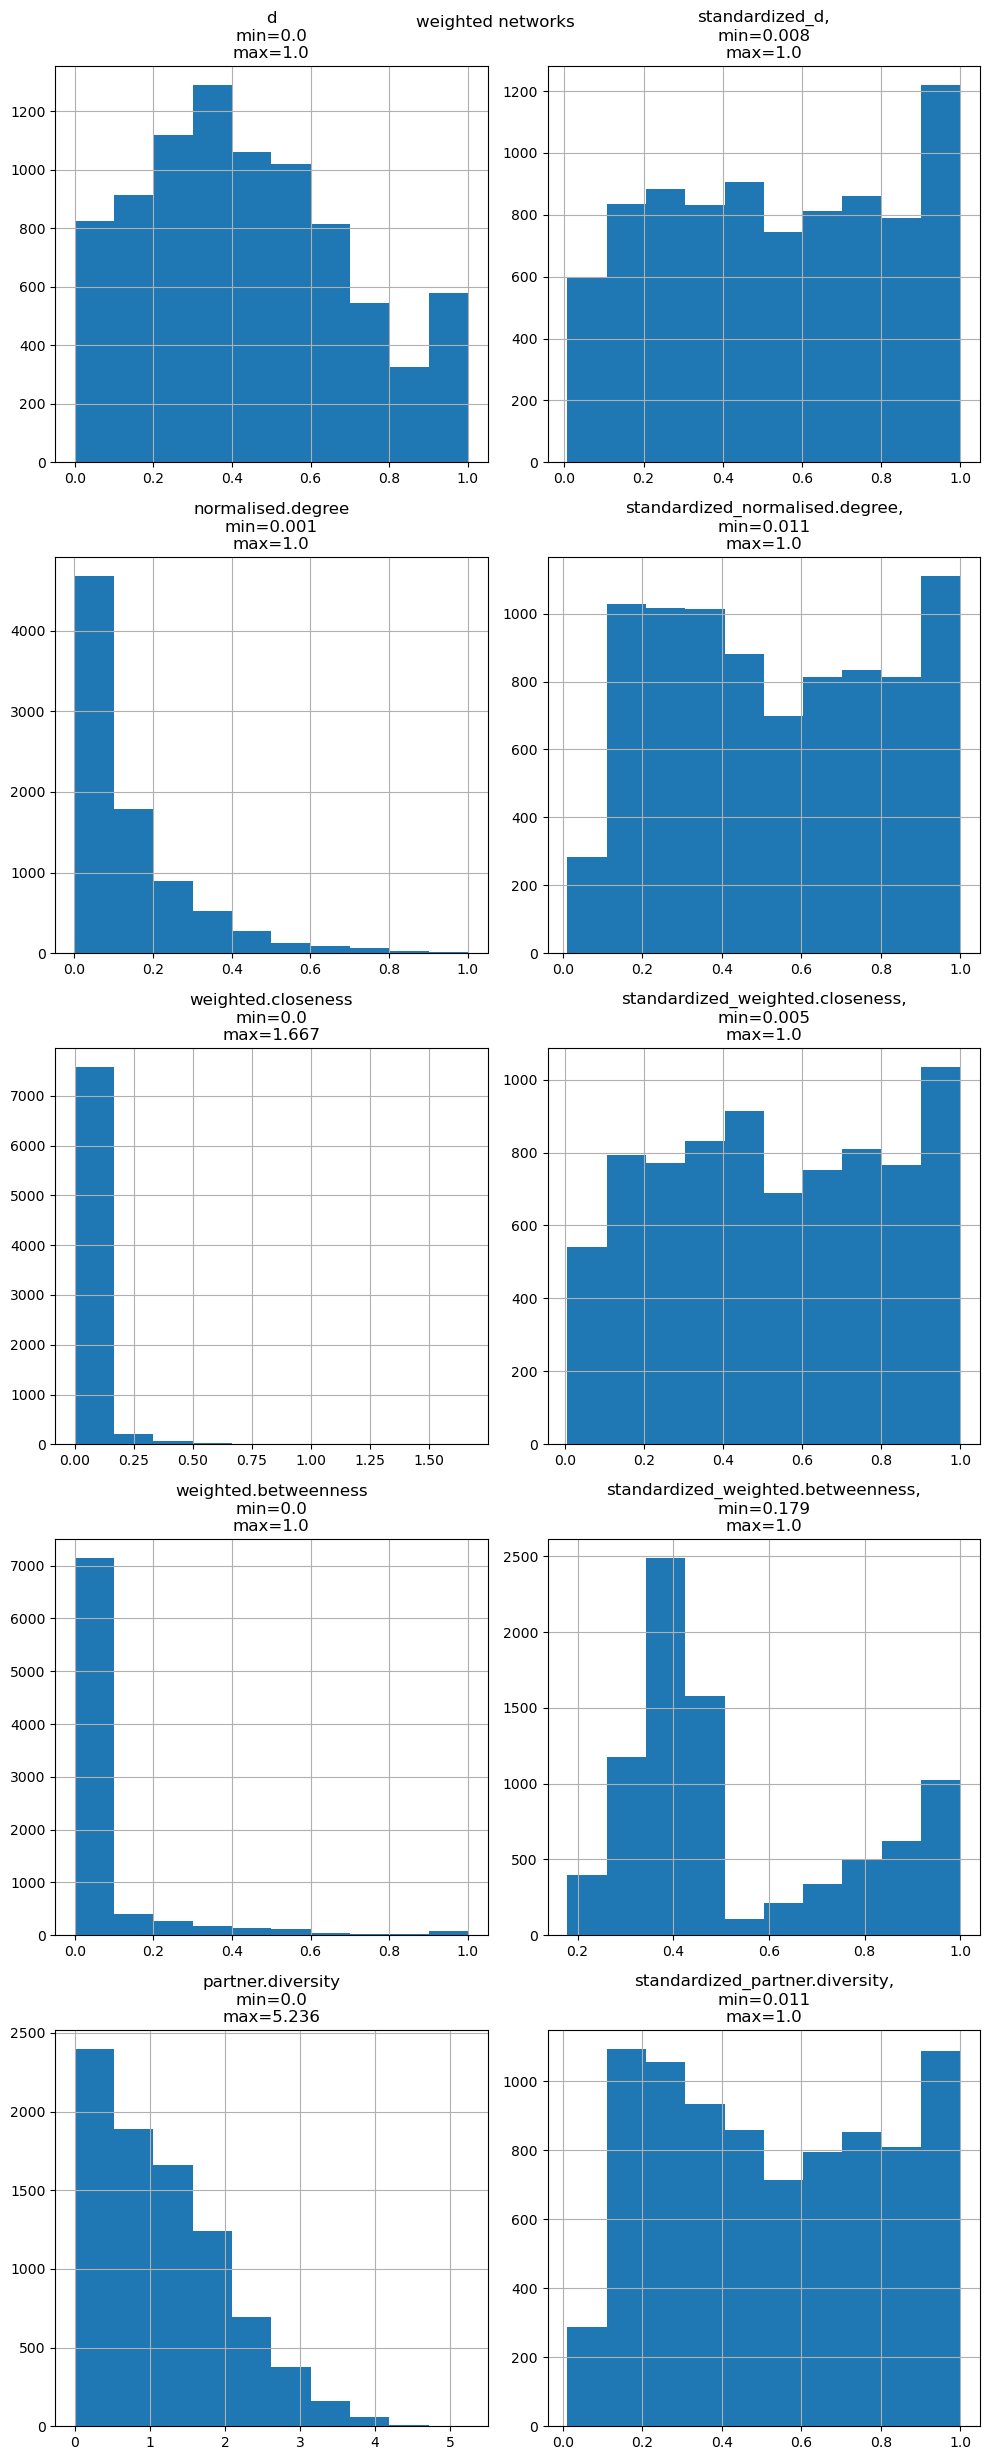

In [20]:
import matplotlib.pyplot as plt
features_to_examine = list(set(features_of_interest["plant"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("weighted")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"weighted networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"standardized_{f}" in relevant_features.columns:
        relevant_features[f"standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"standardized_{f},\nmin={np.round(relevant_features[f'standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{species_features_dir}/weighted_networks_based_feature_distribution.jpeg")

# standarize network features using delta transformation 

In [43]:
def get_standardized_feature(feature, network_id, network_type, alt_val, null_vals):
    if len(null_vals) == 0:
        print(f"no null values available for feature {feature} in {network_type} network {network_id}")
        return np.nan
    # return (alt_val-np.mean(null_vals))
    all_vals = pd.Series([alt_val] + list(null_vals)).dropna()
    return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
    
def add_standardized_features(altenative_features_path: str, null_features_path: str, network_type:str) -> pd.DataFrame:
    alt_db = pd.read_csv(altenative_features_path)
    alt_db = alt_db[[c for c in alt_db.columns if not c.startswith("delta_transformed_ ") and not c.startswith("null_standardized") and not "Unnamed" in c and not c.startswith("normalised") and not c.endswith("rank")]]
    null_db = pd.read_csv(null_features_path)
    features = (set(alt_db.columns) &  set(null_db.columns)) - {"network_id", "network_type", "network"}
    for f in features:
        alt_db[f"null_standardized_{f}"] = alt_db.apply(lambda rec: get_standardized_feature(feature=f,
                                                                                            network_id=rec.network,
                                                                                            network_type=network_type,
                                                                                            alt_val=rec[f],
                                                                                            null_vals=null_db[f].dropna().values), axis=1)
    alt_db.to_csv(altenative_features_path)
    return alt_db

In [44]:
# unite features
for network_type in network_features_dirs:
    features_dir = network_features_dirs[network_type]
    altenative_paths = {int(p.replace("_features.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features.csv")}
    altenative_paths_df = pd.DataFrame.from_dict(altenative_paths, orient="index").rename(columns={0: "alternative_path"})
    null_paths = {int(p.replace("_features_across_null_networks.csv", "")): f"{features_dir}{p}" for p in os.listdir(features_dir) if p.endswith("_features_across_null_networks.csv")}
    null_paths_df = pd.DataFrame.from_dict(null_paths, orient="index").rename(columns={0: "null_path"})
    paths_df = altenative_paths_df.join(null_paths_df, how="inner").reset_index().rename(columns={"index": "network_id"})
    print(f"network type = {network_type}, # networks = {len(altenative_paths.keys()):,}")
    paths_df["res"] = paths_df.parallel_apply(lambda rec: add_standardized_features(altenative_features_path=rec.alternative_path,
                                                                                               null_features_path=rec.null_path,
                                                                                               network_type=network_type), axis=1)
    features = pd.concat([pd.read_csv(alt_path) for alt_path in paths_df.alternative_path])
    features["network_type"] = network_type
    features.to_csv(network_features_output_paths[network_type])

network type = binary, # networks = 176


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature weighted nestedness in binary network 75.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature weighted.cluster.coefficient.LL in binary network 52.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature weighted nestedness in binary network 65.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature specialisation asymmetry in binary network 75.csvno null values available for feature weighted.cluster.coefficient.HL in binary network 52.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binary network 13.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.LL in binary network 75.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature specialisation asymmetry in binary network 65.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 127.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binary network 83.csvno null values available for feature weighted.cluster.coefficient.HL in binary network 75.csvno null values available for feature compartment diversity in binary network 175.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 134.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 140.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature weighted.cluster.coefficient.LL in binary network 65.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature interaction strength asymmetry in binary network 75.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in binary network 65.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature H2 in binary network 75.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature interaction strength asymmetry in binary network 65.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binary network 94.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binary network 4.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted nestedness in binary network 73.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 171.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 160.csv

no null values available for feature compartment diversity in binary network 79.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 179.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature H2 in binary network 65.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 138.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 148.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted nestedness in binary network 53.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 159.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature specialisation asymmetry in binary network 53.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted nestedness in binary network 66.csv
no null values available for feature weighted.cluster.coefficient.LL in binary network 53.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature weighted.cluster.coefficient.HL in binary network 53.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 163.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 151.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature interaction strength asymmetry in binary network 53.csvno null values available for feature compartment diversity in binary network 86.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 123.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binary network 99.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 114.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 161.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature H2 in binary network 53.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature weighted nestedness in binary network 68.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binary network 82.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature specialisation asymmetry in binary network 68.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binary network 101.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 162.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 106.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.LL in binary network 68.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 141.csvno null values available for feature weighted.cluster.coefficient.HL in binary network 68.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 97.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 150.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature interaction strength asymmetry in binary network 68.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 157.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 133.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted.cluster.coefficient.HL in binary network 88.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-

no null values available for feature H2 in binary network 68.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binary network 128.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted.cluster.coefficient.HL in binary network 58.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 168.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 88.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 158.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binary network 70.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 18.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 81.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 60.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature C.score.HL in binary network 154.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 154.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 164.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 142.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature weighted nestedness in binary network 63.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 180.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature weighted.cluster.coefficient.LL in binary network 63.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in binary network 63.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 39.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 149.csvno null values available for feature compartment diversity in binary network 165.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 87.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binary network 177.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 124.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 172.csv
no null values available for feature compartment diversity in binary network 126.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted nestedness in binary network 72.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binary network 156.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 90.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binary network 176.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binary network 169.csv
no null values available for feature compartment diversity in binary network 120.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 147.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binary network 174.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

network type = weighted, # networks = 527


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals

no null values available for feature weighted.cluster.coefficient.HL in weighted network 332.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in weighted network 372.csvno null values available for feature compartment diversity in weighted network 409.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 422.csvno null values available for feature compartment diversity in weighted network 464.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 227.csvno null values available for feature compartment diversity in weighted network 185.csvno null values available for feature compartment diversity in weighted network 430.csv


no null values available for feature compartment diversity in weighted network 523.csvno null values available for feature compartment diversity in weighted network 332.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 229.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in weighted network 238.csvno null values available for feature compartment diversity in weighted network 291.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in weighted network 109.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in weighted network 187.csv
no null values available for feature compartment diversity in weighted network 333.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 190.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 234.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature weighted.cluster.coefficient.HL in weighted network 236.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 365.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in weighted network 282.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 353.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 452.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 236.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 319.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 311.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 210.csv
no null values available for feature compartment diversity in weighted network 188.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in weighted network 382.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 76.csvno null values available for feature compartment diversity in weighted network 189.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in weighted network 268.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 288.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 475.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 255.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 385.csv
no null values available for feature compartment diversity in weighted network 235.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 194.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 106.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 374.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 341.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 431.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 439.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 193.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 4.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 387.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 469.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 191.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 269.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in weighted network 292.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 158.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 209.csv
no null values available for feature compartment diversity in weighted network 292.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 321.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 239.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 389.csv
no null values available for feature compartment diversity in weighted network 423.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 453.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 417.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in weighted network 212.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 281.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 441.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 111.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 454.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 424.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 418.csv
no null values available for feature compartment diversity in weighted network 470.csv
no null values available for feature compartment diversity in weighted network 483.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 5.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 271.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 433.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 444.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 195.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 391.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 337.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted nestedness in weighted network 129.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 303.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 322.csvno null values available for feature compartment diversity in weighted network 362.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 216.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in weighted network 355.csv
no null values available for feature compartment diversity in weighted network 377.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 403.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in weighted network 346.csvno null values available for feature compartment diversity in weighted network 6.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 113.csv

no null values available for feature compartment diversity in weighted network 304.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 262.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 356.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 197.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in weighted network 287.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 420.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 257.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 233.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 215.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 312.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 110.csv
no null values available for feature compartment diversity in weighted network 295.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 104.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in weighted network 218.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 264.csv
no null values available for feature compartment diversity in weighted network 273.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 487.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 447.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 347.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 294.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature weighted nestedness in weighted network 128.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 360.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 393.csvno null values available for feature compartment diversity in weighted network 250.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 274.csv




/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 315.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 458.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 305.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 258.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in weighted network 405.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 394.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 0.csv
no null values available for feature compartment diversity in weighted network 405.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 297.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 253.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 369.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 275.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in weighted network 395.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 73.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 214.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 459.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 7.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 363.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 415.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 306.csv
no null values available for feature weighted nestedness in weighted network 114.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 296.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 223.csv
no null values available for feature compartment diversity in weighted network 494.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 159.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 203.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 349.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in weighted network 379.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 298.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 484.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 479.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 205.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature weighted nestedness in weighted network 131.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 380.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 266.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 329.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted.cluster.coefficient.LL in weighted network 207.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 427.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 160.csvno null values available for feature compartment diversity in weighted network 437.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 350.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 448.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 461.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 396.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature weighted.cluster.coefficient.HL in weighted network 208.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 285.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 481.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 12.csvno null values available for feature compartment diversity in weighted network 370.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 1.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 267.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 465.csv
no null values available for feature compartment diversity in weighted network 308.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 10.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 277.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 381.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 330.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 473.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 397.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 428.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 245.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 482.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 161.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 371.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 74.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 450.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 408.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 307.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 107.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 467.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 184.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 206.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 373.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in weighted network 278.csv
no null values available for feature compartment diversity in weighted network 383.csvno null values available for feature compartment diversity in weighted network 451.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in weighted network 300.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 398.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 300.csv
no null values available for feature compartment diversity in weighted network 466.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in weighted network 186.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in weighted network 310.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in weighted network 406.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in weighted network 2.csv
no null values available for feature compartment diversity in weighted network 232.csv
no null values available for feature compartment diversity in weighted network 289.csv
no null values available for feature compartment diversity in weighted network 468.csv
no null values available for feature compartment diversity in weighted network 310.csv
no null values available for feature compartment diversity in weighted network 108.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in weighted network 414.csv
no null values available for feature compartment diversity in weighted network 75.csv


/tmp/ipykernel_39033/2968355481.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_type"] = network_type


network type = binarized_weighted, # networks = 526


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals

no null values available for feature compartment diversity in binarized_weighted network 74.csv
no null values available for feature compartment diversity in binarized_weighted network 214.csvno null values available for feature compartment diversity in binarized_weighted network 452.csv

no null values available for feature compartment diversity in binarized_weighted network 428.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 372.csv
no null values available for feature compartment diversity in binarized_weighted network 316.csv
no null values available for feature compartment diversity in binarized_weighted network 404.csv
no null values available for feature compartment diversity in binarized_weighted network 453.csv
no null values available for feature compartment diversity in binarized_weighted network 229.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals

no null values available for feature compartment diversity in binarized_weighted network 487.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a


no null values available for feature compartment diversity in binarized_weighted network 250.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 291.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 185.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 450.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 258.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 281.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature weighted nestedness in binarized_weighted network 129.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 108.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 362.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 465.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 315.csv
no null values available for feature compartment diversity in binarized_weighted network 341.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 363.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 333.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-

no null values available for feature compartment diversity in binarized_weighted network 289.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 337.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 190.csv
no null values available for feature compartment diversity in binarized_weighted network 417.csvno null values available for feature compartment diversity in binarized_weighted network 352.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 113.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 197.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 377.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 444.csvno null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 292.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 292.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 467.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 104.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 184.csv
no null values available for feature compartment diversity in binarized_weighted network 191.csvno null values available for feature compartment diversity in binarized_weighted network 408.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 262.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted nestedness in binarized_weighted network 114.csvno null values available for feature compartment diversity in binarized_weighted network 433.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature weighted nestedness in binarized_weighted network 128.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 348.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 464.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 304.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 327.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 459.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 398.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 391.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 188.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 189.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 306.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 430.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 441.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 239.csvno null values available for feature weighted nestedness in binarized_weighted network 131.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 350.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 215.csv
no null values available for feature compartment diversity in binarized_weighted network 293.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 393.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 418.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 427.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 379.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 194.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 353.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 305.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 205.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 294.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 395.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 405.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 264.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 405.csv
no null values available for feature compartment diversity in binarized_weighted network 227.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 295.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 409.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 319.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 259.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 355.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 466.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 310.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 1.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 278.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 109.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 310.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 307.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 374.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 370.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 447.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in binarized_weighted network 275.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 288.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 195.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 312.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 470.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 481.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in binarized_weighted network 329.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 233.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 106.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-

no null values available for feature compartment diversity in binarized_weighted network 469.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 448.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 345.csv
no null values available for feature compartment diversity in binarized_weighted network 186.csv
no null values available for feature compartment diversity in binarized_weighted network 274.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 245.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 380.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 461.csv
no null values available for feature compartment diversity in binarized_weighted network 473.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 482.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 423.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 321.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 75.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 155.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 4.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 300.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 158.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 76.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 454.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 365.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in binarized_weighted network 253.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 192.csvno null values available for feature compartment diversity in binarized_weighted network 300.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 232.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 373.csv
no null values available for feature compartment diversity in binarized_weighted network 212.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 311.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 494.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in binarized_weighted network 277.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 382.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 210.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 479.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 234.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 385.csv



/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 371.csvno null values available for feature compartment diversity in binarized_weighted network 287.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 303.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 2.csv
no null values available for feature compartment diversity in binarized_weighted network 346.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 298.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 159.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 431.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 267.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 332.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 483.csvno null values available for feature compartment diversity in binarized_weighted network 420.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 332.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 396.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 523.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 5.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in binarized_weighted network 209.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 73.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 297.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 266.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 308.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 285.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 347.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 437.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 6.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 236.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 255.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 236.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 206.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 269.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.LL in binarized_weighted network 207.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 424.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 110.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 216.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 468.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 160.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 421.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 107.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 381.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 322.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 360.csv
no null values available for feature compartment diversity in binarized_weighted network 271.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 235.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 475.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 268.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature weighted.cluster.coefficient.HL in binarized_weighted network 208.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 394.csvno null values available for feature compartment diversity in binarized_weighted network 369.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 257.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 422.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 211.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 299.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 484.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 406.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np

no null values available for feature compartment diversity in binarized_weighted network 12.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 349.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.m

no null values available for feature compartment diversity in binarized_weighted network 414.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 367.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 7.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 401.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 356.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 451.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 387.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 161.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 187.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min

no null values available for feature compartment diversity in binarized_weighted network 397.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))



no null values available for feature compartment diversity in binarized_weighted network 238.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 403.csv

/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all

no null values available for feature compartment diversity in binarized_weighted network 389.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(a

no null values available for feature compartment diversity in binarized_weighted network 203.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))


no null values available for feature compartment diversity in binarized_weighted network 284.csv


/tmp/ipykernel_39033/2131351763.py:7: RuntimeWarning: invalid value encountered in long_scalars
  return (alt_val-np.min(all_vals))/(np.max(all_vals)-np.min(all_vals))
/tmp/ipykernel_39033/2968355481.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["network_type"] = network_type


In [45]:
alternative_features_df = pd.concat([pd.read_csv(network_features_output_paths[nt]) for nt in network_features_dirs])

features = ['robustness.LL', 'modularity', 'robustness_mean', 'NODF', 'connectance']


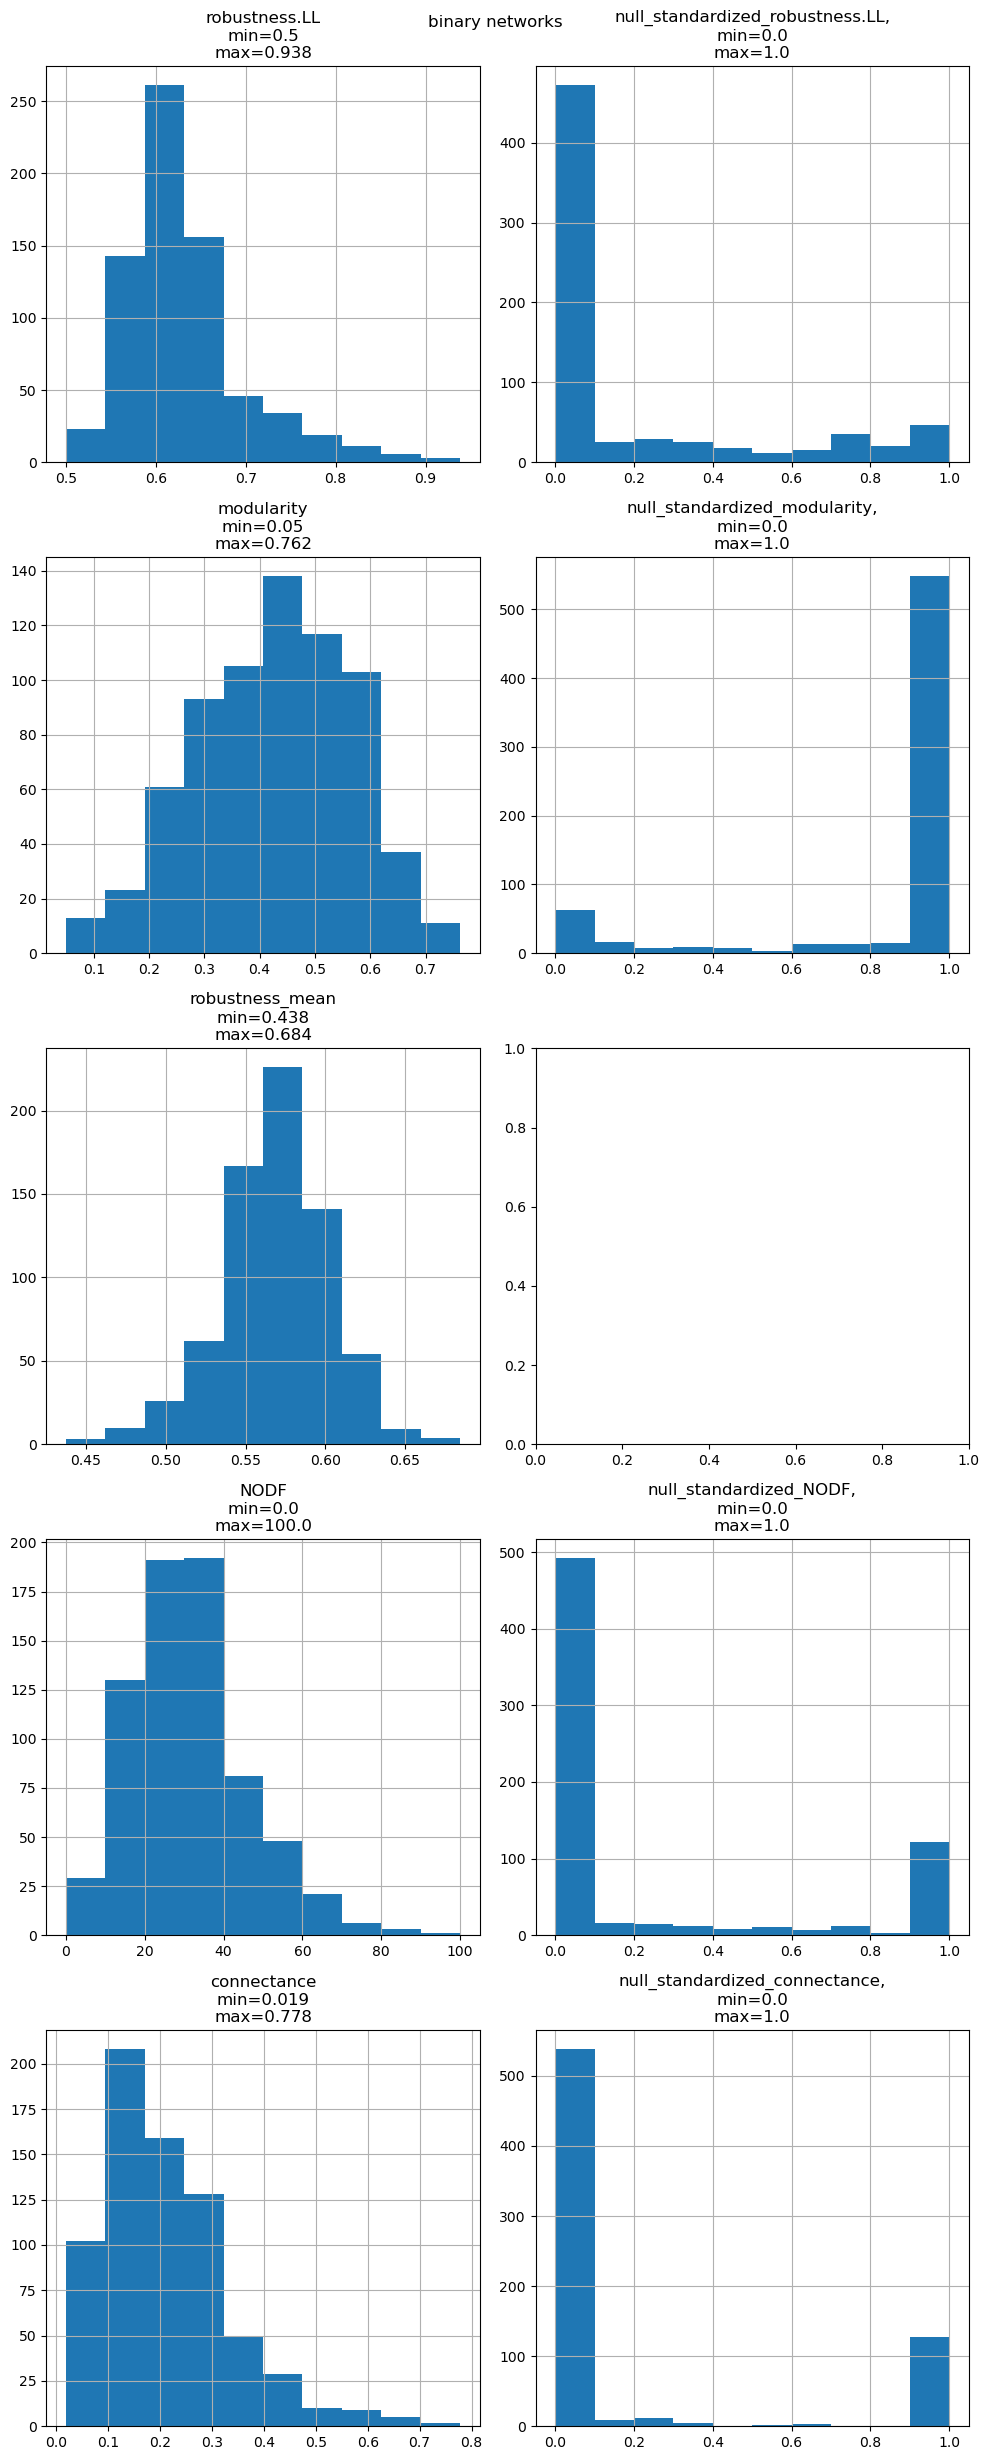

In [46]:
import matplotlib.pyplot as plt

features_to_examine = list(set(features_of_interest["network"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("binar")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"binary networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"null_standardized_{f}" in relevant_features.columns:
        relevant_features[f"null_standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"null_standardized_{f},\nmin={np.round(relevant_features[f'null_standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'null_standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{network_features_dir}/binary_networks_based_feature_distribution.jpeg")

features = ['robustness.LL', 'modularity', 'robustness_mean', 'NODF', 'connectance']


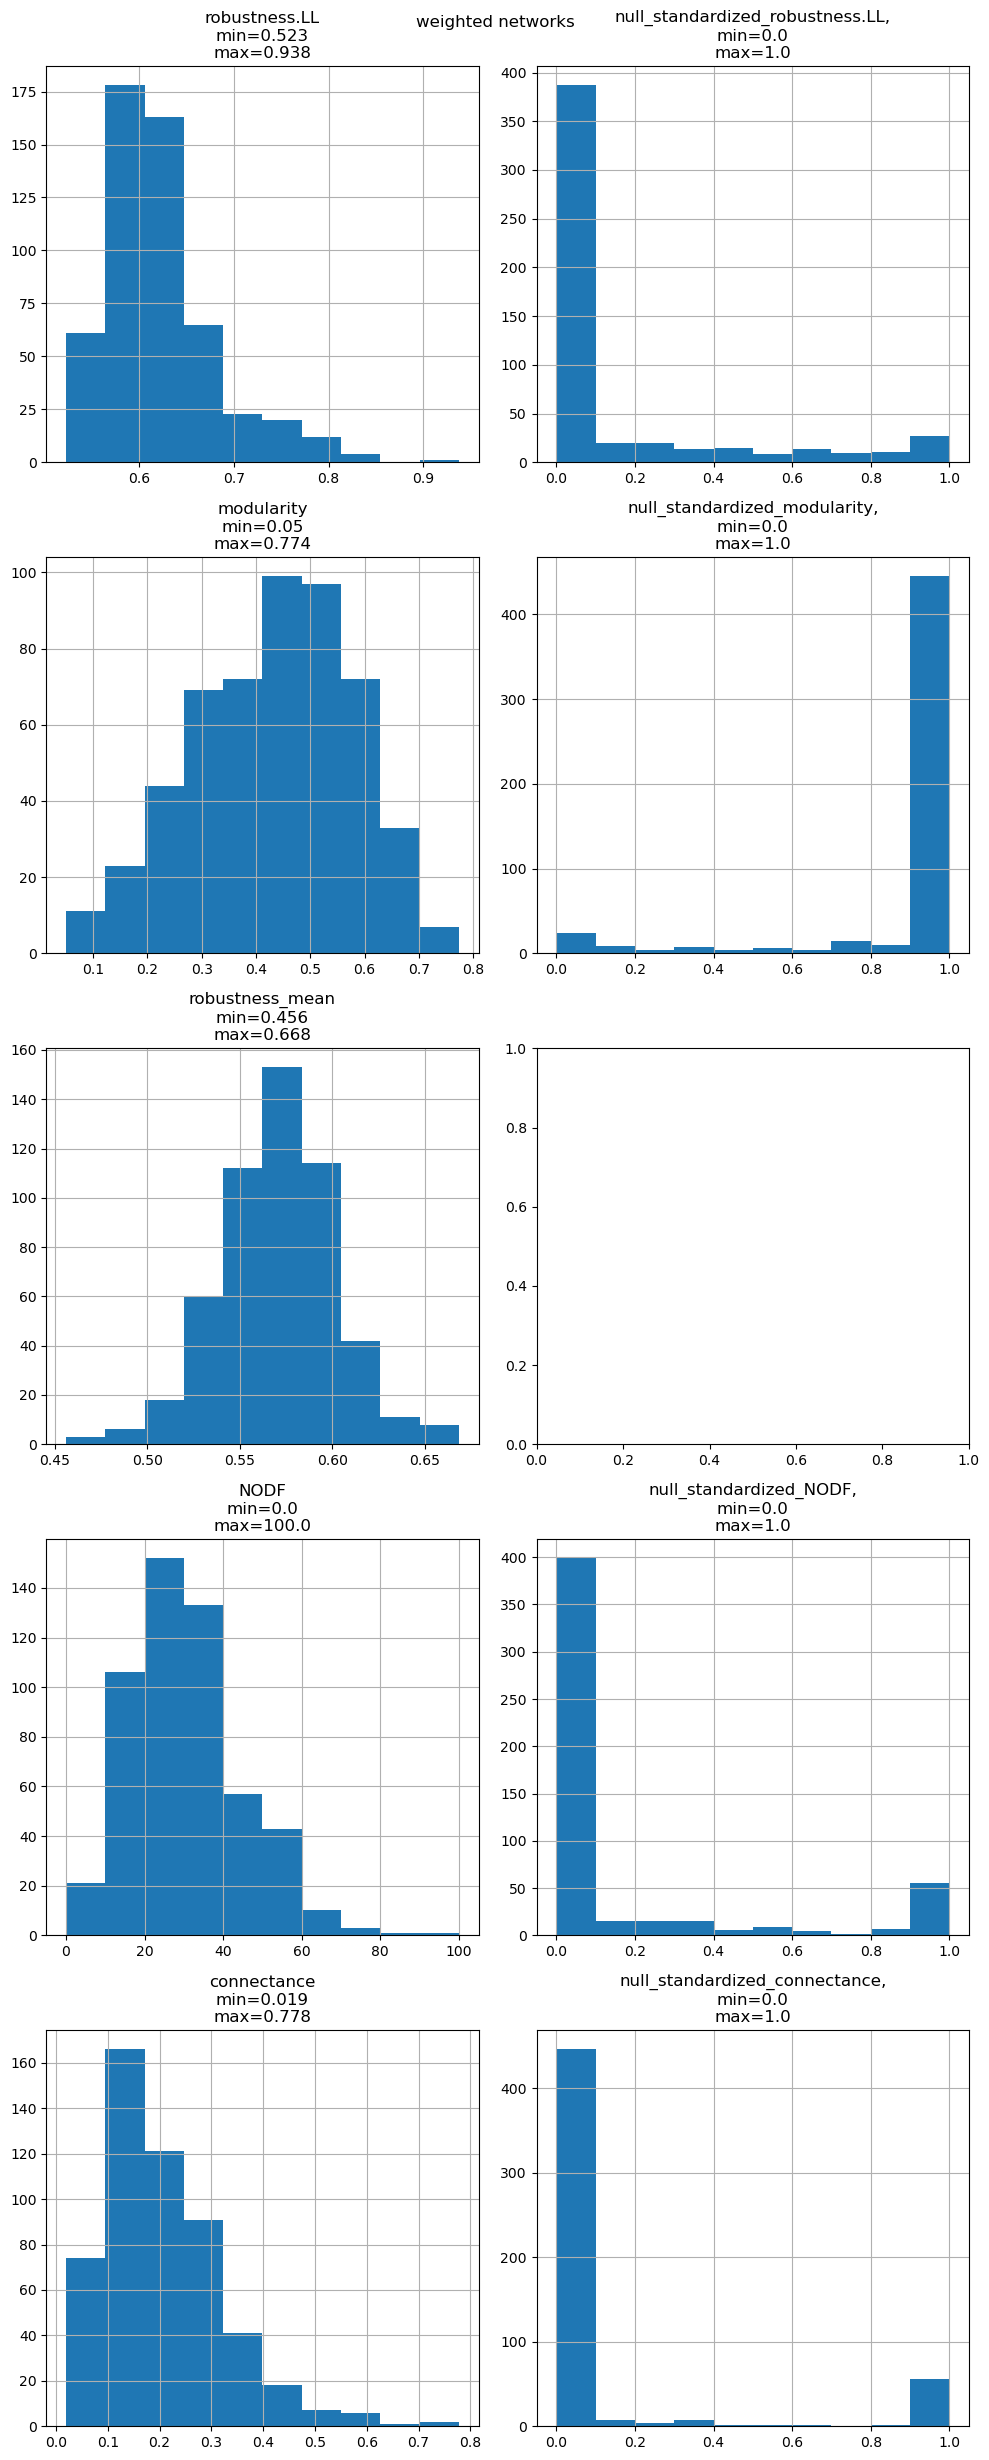

In [47]:
import matplotlib.pyplot as plt

features_to_examine = list(set(features_of_interest["network"])&set(alternative_features_df.columns))
print(f"features = {features_to_examine}")

relevant_features = alternative_features_df.loc[alternative_features_df.network_type.str.startswith("weighted")]
fig, axes = plt.subplots(nrows=len(features_to_examine), ncols=2, figsize=(10, 5*len(features_to_examine)))
fig.suptitle(f"weighted networks")
for i in range(len(features_to_examine)):
    f = features_to_examine[i]
    relevant_features[f].hist(ax=axes[i][0])
    axes[i][0].set_title(f"{f}\nmin={np.round(relevant_features[f].min(),3)}\nmax={np.round(relevant_features[f].max(),3)}")
    if f"null_standardized_{f}" in relevant_features.columns:
        relevant_features[f"null_standardized_{f}"].hist(ax=axes[i][1])
        axes[i][1].set_title(f"null_standardized_{f},\nmin={np.round(relevant_features[f'null_standardized_{f}'].min(),3)}\nmax={np.round(relevant_features[f'null_standardized_{f}'].max(),3)}")
fig.tight_layout()
fig.savefig(f"{network_features_dir}/weighted_networks_based_feature_distribution.jpeg")